Raw data shape: (53420, 24)
     amount          browser    channel  customer_age        date  fraud  \
0  120000.0  Chrome_Some(66)  channel_B          51.0  2018-06-01    0.0   
1    1250.0  Chrome_Some(89)  channel_B          26.0  2021-04-07    0.0   
2     200.0  Chrome_Some(75)  channel_B          82.0  2019-07-31    0.0   
3      30.0  Chrome_Some(77)  channel_B          37.0  2021-04-13    0.0   
4     150.0  Chrome_Some(77)  channel_B          32.0  2021-09-25    0.0   

                ip             isp  latitude                 loginTime  ...  \
0  102.253.144.146  TelkomInternet     -29.0  2018-06-01T19:27:21.000Z  ...   
1    197.89.21.227         OPTINET  -26.3811  2021-04-07T16:10:10.000Z  ...   
2    169.0.104.125   AFRIHOSTOTHER  -26.3811  2019-07-31T14:31:35.000Z  ...   
3     34.252.239.0       Amazoncom   53.3382  2021-04-13T21:12:38.000Z  ...   
4     3.250.216.92       Amazoncom   53.3382  2021-09-25T21:05:45.000Z  ...   

  onceoff_vs_beneficiary                

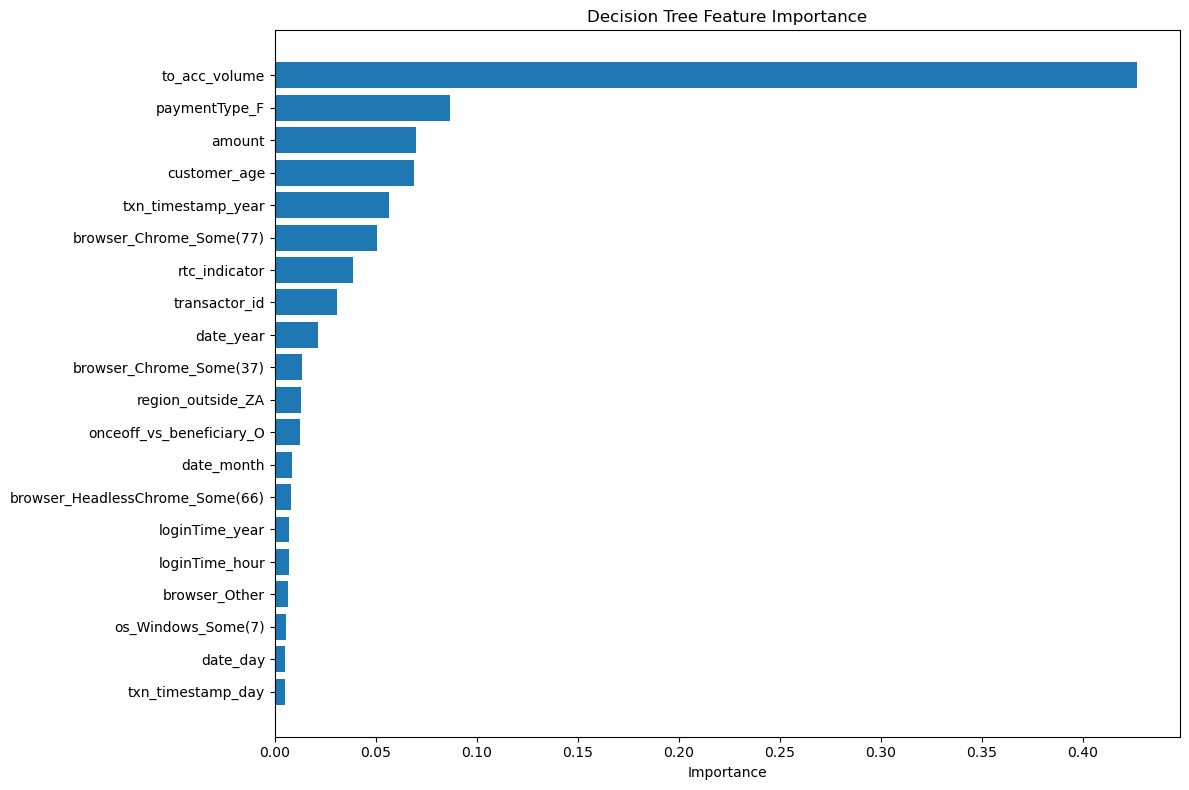


Top 20 Features for Random Forest Feature Importance (No SMOTE):
                 feature  importance
           to_acc_volume    0.200999
                  amount    0.096873
            customer_age    0.066798
           transactor_id    0.048903
      txn_timestamp_hour    0.029709
   browser_Edge_Some(12)    0.028727
onceoff_vs_beneficiary_O    0.027300
              date_month    0.026076
       txn_timestamp_day    0.025360
     txn_timestamp_month    0.025291
                date_day    0.025197
           paymentType_F    0.024135
           minute_of_day    0.023644
               date_year    0.021874
    txn_timestamp_minute    0.021846
    txn_timestamp_second    0.021748
      txn_timestamp_year    0.019408
          loginTime_year    0.017322
          loginTime_hour    0.017292
      os_Android_Some(8)    0.015947


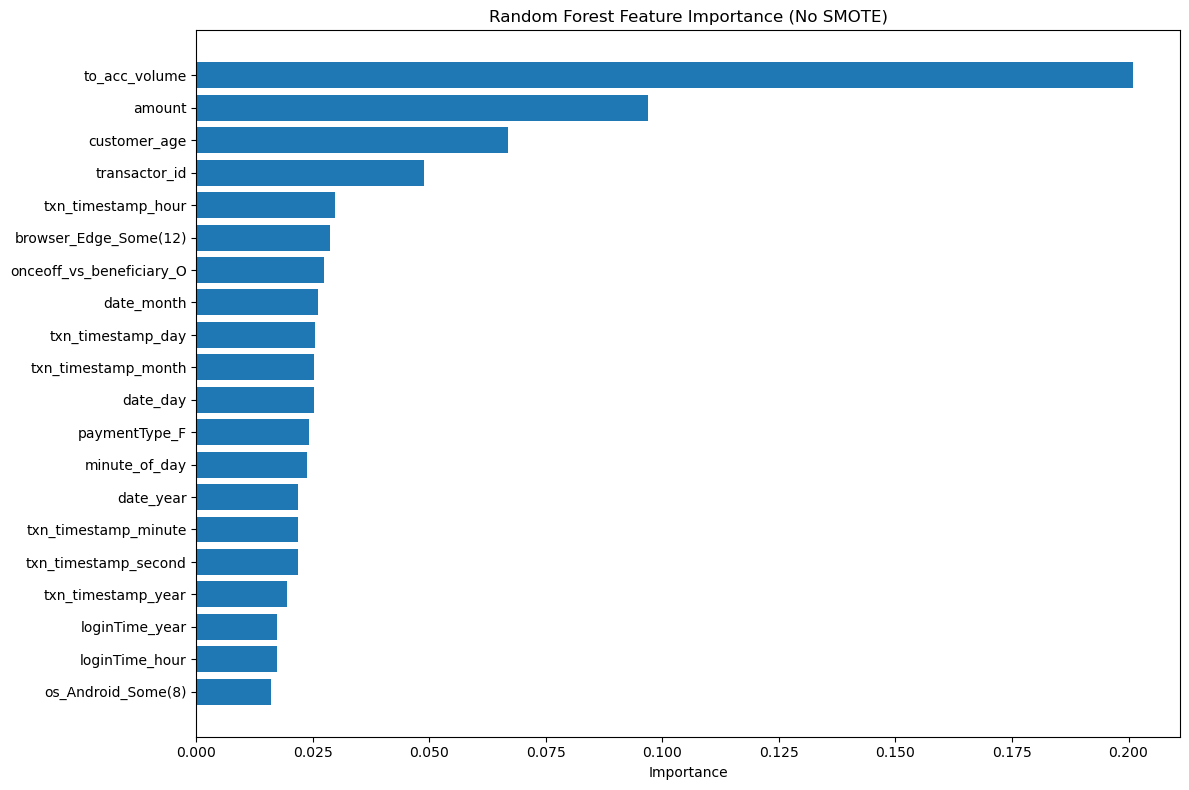


Top 20 Features for Random Forest Feature Importance (With SMOTE):
                 feature  importance
                  amount    0.144352
           to_acc_volume    0.127951
            customer_age    0.069539
          loginTime_year    0.058812
           transactor_id    0.043834
      txn_timestamp_year    0.043673
               date_year    0.042829
            region_ZA_GP    0.038340
     os_Windows_Some(10)    0.030883
          loginTime_hour    0.025932
onceoff_vs_beneficiary_O    0.025613
              date_month    0.025243
      txn_timestamp_hour    0.024569
     txn_timestamp_month    0.022468
         loginTime_month    0.021087
                date_day    0.020990
       txn_timestamp_day    0.020749
           loginTime_day    0.016469
            region_ZA_WC    0.014920
           paymentType_R    0.014698


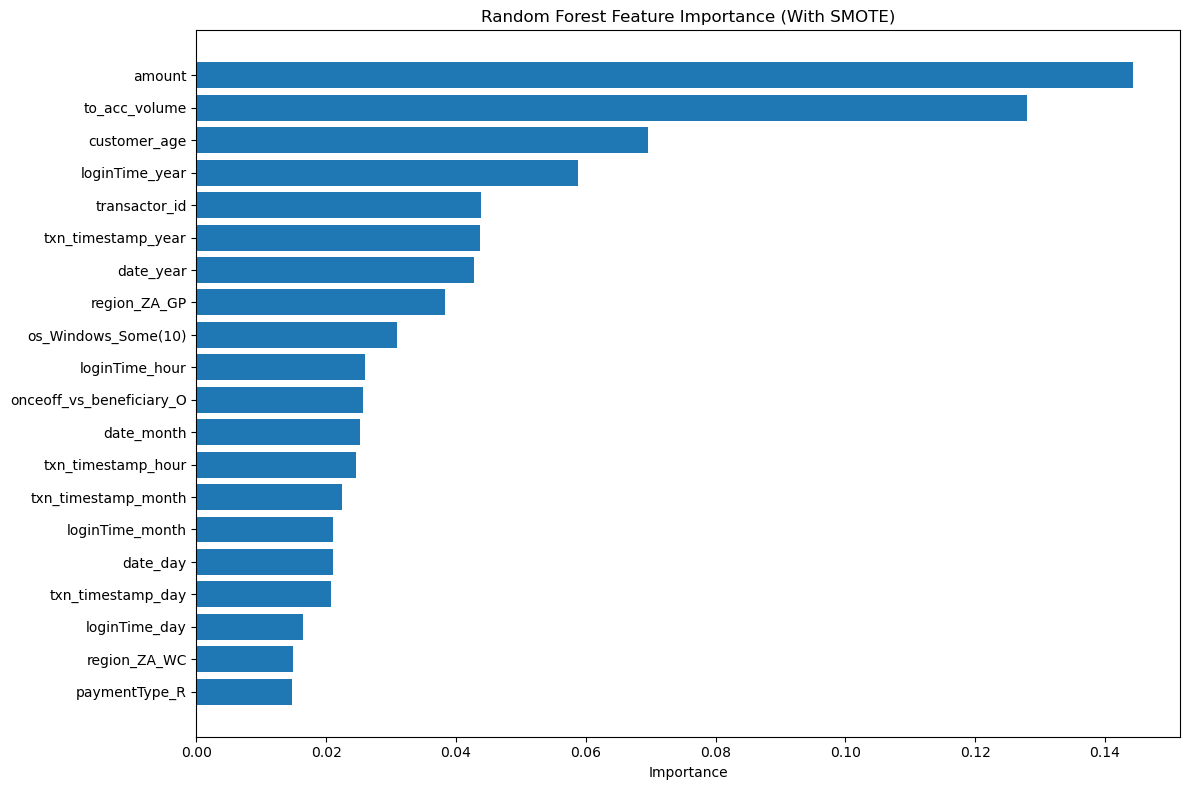


SHAP ANALYSIS
Background data shape: (100, 142)
Background data types: [dtype('float64') dtype('int64') dtype('int32') Sparse[int32, False]]

Creating SHAP explainer...
Test sample shape: (500, 142)
Calculating SHAP values...

Generating SHAP summary plot...


<Figure size 1200x800 with 0 Axes>

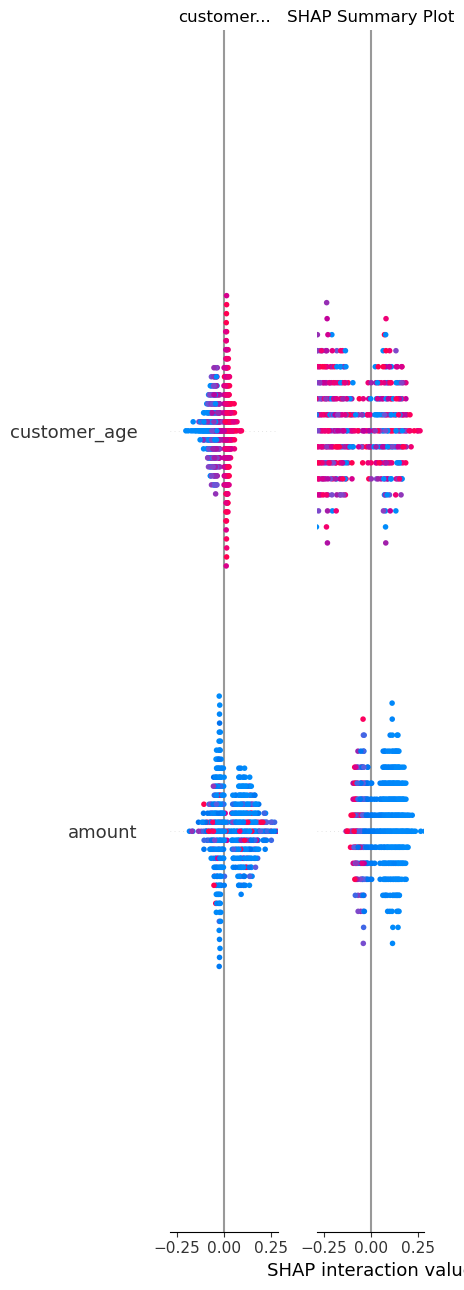


Generating SHAP dependence plot for top feature: amount
 SHAP analysis encountered an error: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50
Continuing with rest of the analysis...

Creating alternative feature importance visualization...


<Figure size 1000x600 with 0 Axes>

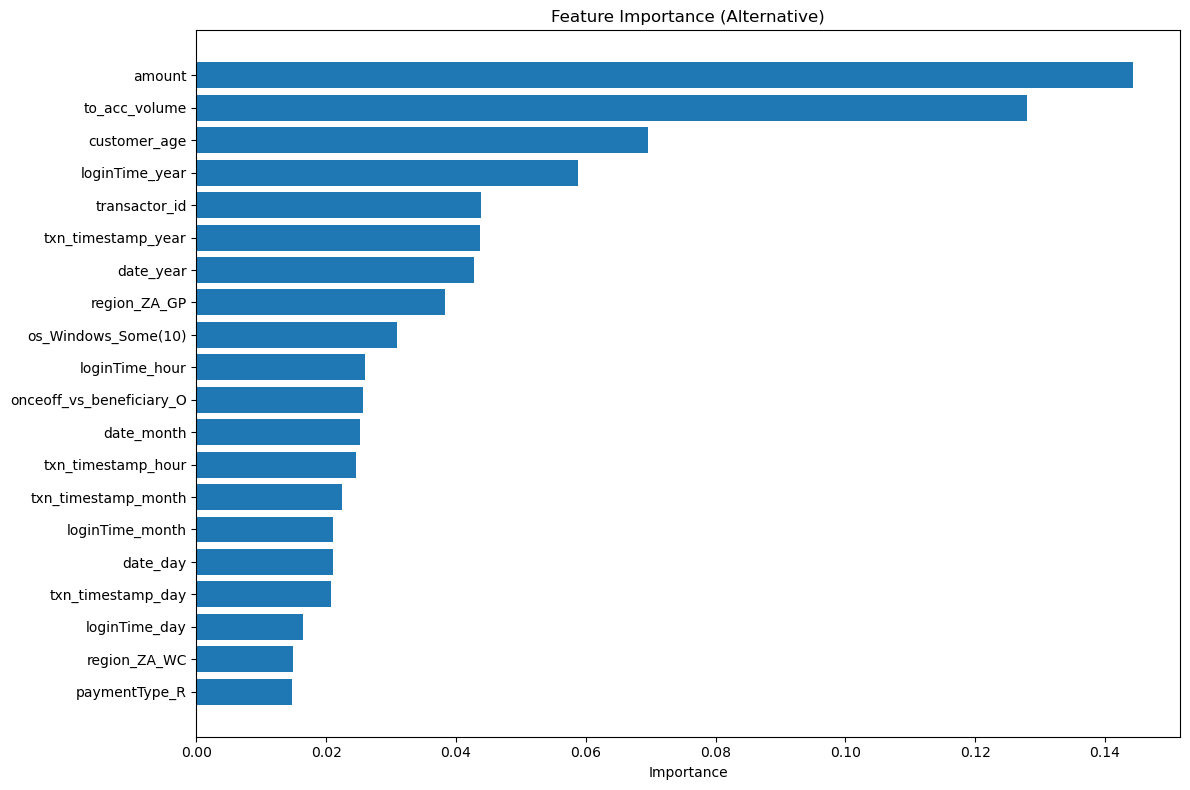


SAVING MODELS FOR DEPLOYMENT
✓ Model saved: models/rf_sm_fraud.pkl
✓ Feature names saved: models/feature_names.json
✓ Preprocessing info saved: models/preprocessing_info.json

MODEL PERFORMANCE SUMMARY

Performance Comparison:
                   Model Accuracy Precision Recall F1-Score  True Positives  False Positives  True Negatives  False Negatives
           Decision Tree   0.9772    0.8704 0.7558   0.8091             517               77            9923              167
Random Forest (No SMOTE)   0.9865    0.9927 0.7953   0.8831             544                4            9996              140
   Random Forest (SMOTE)   0.9876    0.9409 0.8611   0.8992             589               37            9963               95


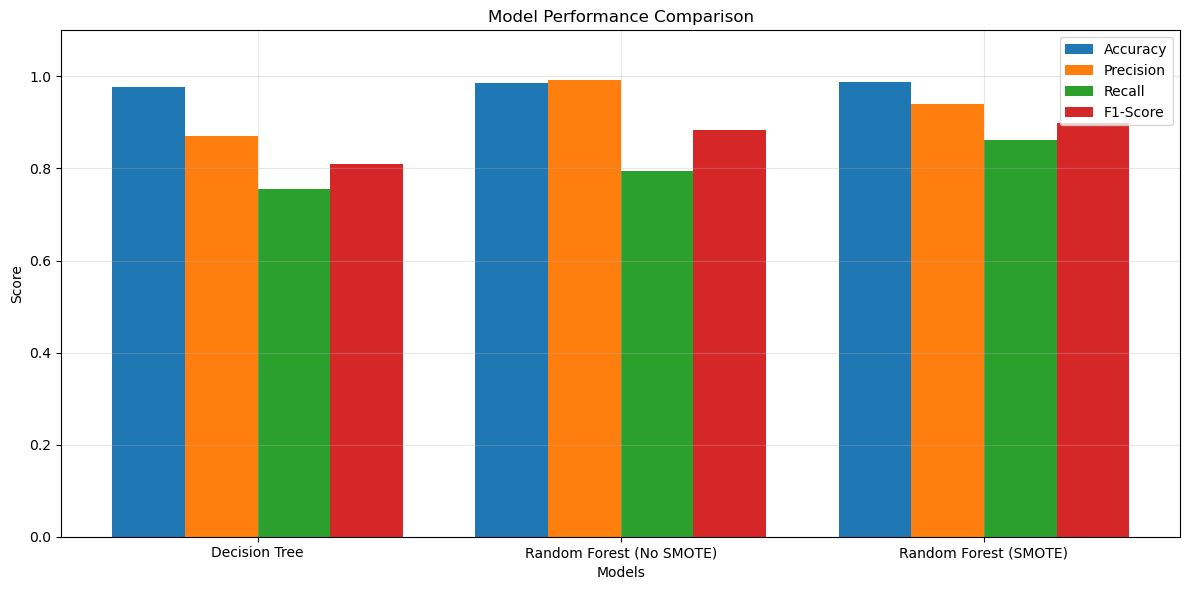


PREDICTION PIPELINE FOR NEW DATA

Testing prediction function with sample data...
Cleaned data shape: (5, 25)
Data types after cleaning:
int32      13
float64    11
int64       1
Name: count, dtype: int64
Fraud distribution: fraud
0    5
Name: count, dtype: int64

Sample predictions:
   prediction  fraud_probability  is_fraud
0           0              0.335     False
1           0              0.180     False
2           0              0.460     False
3           0              0.110     False
4           0              0.040     False

PROJECT COMPLETED SUCCESSFULLY!

SUMMARY:
1. Dataset: 53420 rows, 24 columns
2. After cleaning: 53420 rows, 143 features
3. Fraud rate: 6.40%
4. Best model accuracy: 0.9876
5. Files created:
   - cleaned_df.pkl
   - models/rf_sm_fraud.pkl
   - models/feature_names.json
   - models/preprocessing_info.json

NEXT STEPS:
1. Use predict_fraud() function for new predictions
2. Monitor model performance with new data
3. Consider hyperparameter tuning for fur

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import json
import shap
import warnings
import os
warnings.filterwarnings('ignore')

# Load the raw data
data = pd.read_csv("fraud_dataset_raw.csv")
print(f"Raw data shape: {data.shape}")
print(data.head())

# ===== 2. COMPLETE DATA CLEANING PIPELINE =====
def clean_data(df):
    """Complete data cleaning and preprocessing pipeline"""
    df_clean = df.copy()
    
    # 1. Drop unnecessary columns
    cols_to_drop = [
        "uuid", "lut_first_paid_date", "lut_last_paid_date",
        "ip", "isp", "latitude", "longitude", "to_bank"
    ]
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')
    
    # 2. Convert datetime columns and extract features
    datetime_cols = ["date", "loginTime", "txn_timestamp"]
    
    for col in datetime_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
            
            # Extract datetime components
            df_clean[col + "_year"] = df_clean[col].dt.year
            df_clean[col + "_month"] = df_clean[col].dt.month
            df_clean[col + "_day"] = df_clean[col].dt.day
            df_clean[col + "_hour"] = df_clean[col].dt.hour
            df_clean[col + "_minute"] = df_clean[col].dt.minute
            df_clean[col + "_second"] = df_clean[col].dt.second
    
    # Drop original datetime columns
    df_clean = df_clean.drop(columns=datetime_cols, errors = 'ignore')
    
    # 3. Fill missing values
    for col in df_clean.columns:
        if df_clean[col].dtype == "object":
            df_clean[col] = df_clean[col].fillna("unknown")
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # 4. Encode categorical columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    
    # Group rare categories (threshold can be increased if you hit MemoryError)
    THRESH = 50
    for c in categorical_cols:
        vc = df_clean[c].value_counts(dropna = False)
        if len(vc) > 0:
            frequent = set(vc[vc >= THRESH].index)
            df_clean[c] = df_clean[c].where(df_clean[c].isin(frequent), other = "Other")
            
    # Now one-hot encode, but create sparse dummies to save memory
    df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first = True, sparse = True)
    
    # 5. Ensure 'fraud' column exists and is binary
    if 'fraud' in df_clean.columns:
        df_clean['fraud'] = df_clean['fraud'].astype(int)
    
    # 6. CRITICAL: Convert all columns to numeric for SHAP compatibility
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            try:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            except:
                df_clean[col] = df_clean[col].astype('category').cat.codes
    
    # Fill any new NaN values created during conversion
    df_clean = df_clean.fillna(0)
    
    print(f"Cleaned data shape: {df_clean.shape}")
    print(f"Data types after cleaning:")
    print(df_clean.dtypes.value_counts())
    print(f"Fraud distribution: {df_clean['fraud'].value_counts()}")
    
    return df_clean

# Apply cleaning
df_cleaned = clean_data(data)

# Save cleaned data for future use
df_cleaned.to_pickle("cleaned_df.pkl")
print("Cleaned data saved as 'cleaned_df.pkl'")

# ===== 3. MODEL TRAINING =====

# Separate features and target
X = df_cleaned.drop("fraud", axis=1)
y = df_cleaned["fraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Fraud ratio in training: {y_train.mean():.4f}")

# ===== 4. DECISION TREE MODEL =====
print("\n" + "="*50)
print("DECISION TREE MODEL")
print("="*50)

dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# ===== 5. RANDOM FOREST WITHOUT SMOTE =====
print("\n" + "="*50)
print("RANDOM FOREST (NO SMOTE)")
print("="*50)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# ===== 6. SMOTE BALANCING =====
print("\n" + "="*50)
print("APPLYING SMOTE")
print("="*50)

# Apply SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_sm.value_counts())

# ===== 7. RANDOM FOREST WITH SMOTE =====
print("\n" + "="*50)
print("RANDOM FOREST (WITH SMOTE)")
print("="*50)

rf_sm = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_sm.fit(X_train_sm, y_train_sm)
y_pred_rf_sm = rf_sm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_sm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_sm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_sm))

# ===== 8. FEATURE IMPORTANCE ANALYSIS =====
def plot_feature_importance(model, X, title, top_n=20):
    """Fixed function to plot feature importance"""
    importances = model.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    # Display top features
    print(f"\nTop {top_n} Features for {title}:")
    print(fi_df.head(top_n).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(fi_df.head(top_n)['feature'], fi_df.head(top_n)['importance'])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
    
    return fi_df

# Plot feature importance for all models
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Decision Tree
fi_dt = plot_feature_importance(dt, X_train, "Decision Tree Feature Importance")

# Random Forest (No SMOTE)
fi_rf = plot_feature_importance(rf, X_train, "Random Forest Feature Importance (No SMOTE)")

# Random Forest (With SMOTE)
fi_rf_sm = plot_feature_importance(rf_sm, X_train_sm, "Random Forest Feature Importance (With SMOTE)")

# ===== 9. SHAP ANALYSIS (WITH ERROR HANDLING) =====
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

try:
    # Ensure all data is numeric for SHAP
    X_train_sm_numeric = X_train_sm.copy()
    X_test_numeric = X_test.copy()
    
    # Convert any remaining object columns
    for col in X_train_sm_numeric.columns:
        if X_train_sm_numeric[col].dtype == 'object':
            X_train_sm_numeric[col] = pd.to_numeric(X_train_sm_numeric[col], errors='coerce')
        if col in X_test_numeric.columns and X_test_numeric[col].dtype == 'object':
            X_test_numeric[col] = pd.to_numeric(X_test_numeric[col], errors='coerce')
    
    # Fill NaN values
    X_train_sm_numeric = X_train_sm_numeric.fillna(0)
    X_test_numeric = X_test_numeric.fillna(0)
    
    # Prepare background data (small sample for speed)
    background = X_train_sm_numeric.sample(n=100, random_state=42)
    
    print(f"Background data shape: {background.shape}")
    print(f"Background data types: {background.dtypes.unique()}")
    
    # Create SHAP explainer - SIMPLER VERSION
    print("\nCreating SHAP explainer...")
    explainer = shap.TreeExplainer(rf_sm)
    
    # Calculate SHAP values for a small sample
    X_test_sample = X_test_numeric.sample(n=min(500, len(X_test_numeric)), random_state=42)
    print(f"Test sample shape: {X_test_sample.shape}")
    
    # Calculate SHAP values
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(X_test_sample)
    
    # SHAP summary plot
    print("\nGenerating SHAP summary plot...")
    plt.figure(figsize=(12, 8))
    
    # For binary classification, shap_values is a list [negative_class, positive_class]
    if isinstance(shap_values, list) and len(shap_values) == 2:
        # Use positive class (fraud = 1)
        shap.summary_plot(shap_values[1], X_test_sample, max_display=15, show=False)
        plt.title("SHAP Summary Plot - Fraud Class (1)")
    else:
        # If it's not a list, use directly
        shap.summary_plot(shap_values, X_test_sample, max_display=15, show=False)
        plt.title("SHAP Summary Plot")
    
    plt.tight_layout()
    plt.show()
    
    # SHAP dependence plot for top feature
    top_feature = fi_rf_sm.iloc[0]['feature']
    if top_feature in X_test_sample.columns:
        print(f"\nGenerating SHAP dependence plot for top feature: {top_feature}")
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(top_feature, shap_values[1] if isinstance(shap_values, list) else shap_values, 
                           X_test_sample, show=False)
        plt.title(f"SHAP Dependence Plot for {top_feature}")
        plt.tight_layout()
        plt.show()
    
    # Waterfall plot for a single example
    print("\nGenerating waterfall plot for first example...")
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(explainer(X_test_sample.iloc[0:1])[0], max_display=15, show=False)
    plt.title("Waterfall Plot - Single Prediction Explanation")
    plt.tight_layout()
    plt.show()
    
    print("✓ SHAP analysis completed successfully!")
    
except Exception as e:
    print(f" SHAP analysis encountered an error: {e}")
    print("Continuing with rest of the analysis...")
    
    # Alternative: simpler feature importance visualization
    print("\nCreating alternative feature importance visualization...")
    
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_sm.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance.head(20)['feature'][::-1], 
            feature_importance.head(20)['importance'][::-1])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Alternative)')
    plt.tight_layout()
    plt.show()

# ===== 10. MODEL SAVING =====
print("\n" + "="*50)
print("SAVING MODELS FOR DEPLOYMENT")
print("="*50)

# Create models directory
import os
os.makedirs("models", exist_ok=True)

# Save the best model (Random Forest with SMOTE)
joblib.dump(rf_sm, "models/rf_sm_fraud.pkl")

# Save feature names in correct order
feature_names = list(X_train_sm.columns)
with open("models/feature_names.json", "w") as f:
    json.dump(feature_names, f)

# Save the preprocessing info
preprocessing_info = {
    'dropped_columns': [
        "uuid", "lut_first_paid_date", "lut_last_paid_date",
        "ip", "isp", "latitude", "longitude", "to_bank"
    ],
    'datetime_columns': ["date", "loginTime", "txn_timestamp"],
    'categorical_encoding': 'one_hot',
    'missing_value_strategy': {
        'categorical': 'fill_with_unknown',
        'numerical': 'fill_with_median'
    },
    'target_column': 'fraud'
}

with open("models/preprocessing_info.json", "w") as f:
    json.dump(preprocessing_info, f, indent=2)

print("✓ Model saved: models/rf_sm_fraud.pkl")
print("✓ Feature names saved: models/feature_names.json")
print("✓ Preprocessing info saved: models/preprocessing_info.json")

# ===== 11. MODEL EVALUATION SUMMARY =====
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)

models = {
    'Decision Tree': (dt, y_pred_dt),
    'Random Forest (No SMOTE)': (rf, y_pred_rf),
    'Random Forest (SMOTE)': (rf_sm, y_pred_rf_sm)
}

summary_data = []
for name, (model, preds) in models.items():
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    summary_data.append({
        'Model': name,
        'Accuracy': f"{acc:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}",
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    })

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Comparison:")
print(summary_df.to_string(index=False))

# Plot performance comparison
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = [float(row[metric]) for row in summary_data]
    plt.bar(x + i*width - width*1.5, values, width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, [row['Model'] for row in summary_data])
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 12. PREDICTION FUNCTION FOR NEW DATA =====
print("\n" + "="*50)
print("PREDICTION PIPELINE FOR NEW DATA")
print("="*50)

def predict_fraud(new_data, model_path="models/rf_sm_fraud.pkl"):
    """
    Predict fraud for new data
    
    Parameters:
    new_data: DataFrame with same structure as original data
    model_path: Path to saved model
    
    Returns:
    predictions: Array of predictions (0=not fraud, 1=fraud)
    probabilities: Array of fraud probabilities
    """
    
    # Load model and feature names
    model = joblib.load(model_path)
    
    with open("models/feature_names.json", "r") as f:
        required_features = json.load(f)
    
    # Clean the new data (using same pipeline)
    new_data_clean = clean_data(new_data)
    
    # Ensure all required features are present
    missing_features = set(required_features) - set(new_data_clean.columns)
    extra_features = set(new_data_clean.columns) - set(required_features)
    
    if missing_features:
        print(f"Warning: {len(missing_features)} missing features")
        # Add missing features with default value 0
        for feature in missing_features:
            new_data_clean[feature] = 0
    
    # Remove extra features
    new_data_clean = new_data_clean[required_features]
    
    # Ensure all data is numeric
    for col in new_data_clean.columns:
        if new_data_clean[col].dtype == 'object':
            new_data_clean[col] = pd.to_numeric(new_data_clean[col], errors='coerce')
    
    new_data_clean = new_data_clean.fillna(0)
    
    # Make predictions
    predictions = model.predict(new_data_clean)
    probabilities = model.predict_proba(new_data_clean)[:, 1]
    
    # Create results DataFrame
    results = pd.DataFrame({
        'prediction': predictions,
        'fraud_probability': probabilities,
        'is_fraud': predictions == 1
    })
    
    return results

# Test the prediction function with a sample
print("\nTesting prediction function with sample data...")
sample_data = data.sample(n=5, random_state=42)
predictions = predict_fraud(sample_data)
print("\nSample predictions:")
print(predictions)

# ===== 13. FINAL SUMMARY =====
print("\n" + "="*50)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*50)

print(f"""
SUMMARY:
1. Dataset: {data.shape[0]} rows, {data.shape[1]} columns
2. After cleaning: {df_cleaned.shape[0]} rows, {df_cleaned.shape[1]} features
3. Fraud rate: {y.mean():.2%}
4. Best model accuracy: {accuracy_score(y_test, y_pred_rf_sm):.4f}
5. Files created:
   - cleaned_df.pkl
   - models/rf_sm_fraud.pkl
   - models/feature_names.json
   - models/preprocessing_info.json

NEXT STEPS:
1. Use predict_fraud() function for new predictions
2. Monitor model performance with new data
3. Consider hyperparameter tuning for further improvement
""")

# Save the complete notebook state
with open("FNB_Fraud_Detection_Project_(Working Code).py", "w") as f:
    f.write("# Complete Fraud Detection Pipeline\n")
    f.write("# Generated on: " + pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))
print("✓ Complete script saved as 'FNB_Fraud_Detection_Project_(Working Code).py'")